In [29]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [36]:
# Read in the trip summary data
file_path = '../data/trip_summary_201901.csv'
trips = pd.read_csv(file_path).dropna()
print(len(trips))
print(trips['start_station_id'].nunique())
trips.head()

124502
152


,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count
0,2019-01-01,0,109,17th St at Valencia St,23.0,True,141,Valencia St at Cesar Chavez St,19.0,True,37.763316,-122.421904,37.747998,-122.420219,390,6.500000,1,1,0
1,2019-01-01,0,109,17th St at Valencia St,23.0,True,91,Berry St at King St,23.0,True,37.763316,-122.421904,37.771762,-122.398438,780,13.000000,1,1,0
2,2019-01-01,0,118,Eureka Valley Recreation Center,19.0,True,126,Esprit Park,31.0,True,37.759177,-122.436943,37.761634,-122.390648,1306,21.766667,1,1,0
3,2019-01-01,0,119,18th St at Noe St,15.0,True,98,Valencia St at 16th St,23.0,True,37.761047,-122.432642,37.765052,-122.421866,422,7.033333,1,1,0
4,2019-01-01,0,120,Mission Dolores Park,27.0,True,98,Valencia St at 16th St,23.0,True,37.761420,-122.426435,37.765052,-122.421866,277,4.616667,1,1,0


In [39]:
# Data quality checks
print('Number of NaNs in the dataframe:\n', trips.isnull().sum())

Number of NaNs in the dataframe:
 start_date                 0
start_hour                 0
start_station_id           0
start_station_name         0
start_station_cap          0
start_station_has_kiosk    0
end_station_id             0
end_station_name           0
end_station_cap            0
end_station_has_kiosk      0
start_station_latitude     0
start_station_longitude    0
end_station_latitude       0
end_station_longitude      0
sum_duration_sec           0
sum_duration_min           0
trip_count                 0
subscriber_trip_count      0
customer_trip_count        0
start_dow                  0
dtype: int64


In [37]:
# Feature engineering
trips['start_dow'] = trips['start_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')).dt.weekday_name
trips

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,start_dow
0,2019-01-01,0,109,17th St at Valencia St,23.0,True,141,Valencia St at Cesar Chavez St,19.0,True,37.763316,-122.421904,37.747998,-122.420219,390,6.500000,1,1,0,Tuesday
1,2019-01-01,0,109,17th St at Valencia St,23.0,True,91,Berry St at King St,23.0,True,37.763316,-122.421904,37.771762,-122.398438,780,13.000000,1,1,0,Tuesday
2,2019-01-01,0,118,Eureka Valley Recreation Center,19.0,True,126,Esprit Park,31.0,True,37.759177,-122.436943,37.761634,-122.390648,1306,21.766667,1,1,0,Tuesday
3,2019-01-01,0,119,18th St at Noe St,15.0,True,98,Valencia St at 16th St,23.0,True,37.761047,-122.432642,37.765052,-122.421866,422,7.033333,1,1,0,Tuesday
4,2019-01-01,0,120,Mission Dolores Park,27.0,True,98,Valencia St at 16th St,23.0,True,37.761420,-122.426435,37.765052,-122.421866,277,4.616667,1,1,0,Tuesday
5,2019-01-01,0,121,Mission Playground,23.0,True,144,Precita Park,15.0,True,37.759210,-122.421339,37.747300,-122.411403,350,5.833333,1,0,1,Tuesday
6,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,377,Fell St at Stanyan St,19.0,True,37.794231,-122.402923,37.771917,-122.453704,3421,57.016667,2,2,0,Tuesday
7,2019-01-01,0,13,Commercial St at Montgomery St,23.0,True,62,Victoria Manalo Draves Park,15.0,True,37.794231,-122.402923,37.777791,-122.406432,930,15.500000,1,0,1,Tuesday
8,2019-01-01,0,138,Jersey St at Church St,19.0,True,145,29th St at Church St,15.0,True,37.750900,-122.427411,37.743684,-122.426806,135,2.250000,1,1,0,Tuesday
9,2019-01-01,0,15,San Francisco Ferry Building (Harry Bridges Pl...,38.0,True,34,Father Alfred E Boeddeker Park,23.0,True,37.795392,-122.394203,37.783988,-122.412408,1325,22.083333,2,2,0,Tuesday


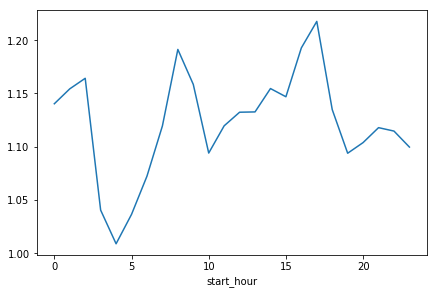

In [32]:
# Plot trip counts by start_hour to check if timezone is correct

# To print pyplot output inline in the notebook withput calling plt.show()
%matplotlib inline

# Increase standard plot size
plt.rcParams['figure.figsize'] = (7, 4.5)

trips_by_hour = trips.groupby('start_hour')['trip_count'].mean()
trips_by_hour.plot()

# Comment: we can see that the peaks in activity happen in the morning and late afternoon.
# This indicates that the timezone of the datetimes are in PST.

In [70]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = trips[['start_hour'
           , 'start_station_id'
           , 'start_station_cap'
           , 'start_station_has_kiosk'
           , 'end_station_id'
           , 'end_station_cap'
           , 'end_station_has_kiosk'
           , 'start_station_latitude'
           , 'start_station_longitude'
           , 'end_station_latitude'
           , 'end_station_longitude'
           , 'sum_duration_min'
           , 'start_dow']]
y = trips['trip_count']

onehot_cols = ['start_station_id', 'end_station_id', 'start_dow']

for k, v in enumerate(onehot_cols):    
    one_hot = pd.get_dummies(X[v], prefix=v)
    X = X.drop(v, axis=1) # drop column as it is now encoded
    X = X.join(one_hot) # join the encoded df
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print ('Number of samples in training data:',len(x_train))
print ('Number of samples in test data:',len(x_test))

Number of samples in training data: 99601
Number of samples in test data: 24901


Test Score:  0.12325380319226842
Test Score:  0.12405892896957095
RRS:  5928.180761024356


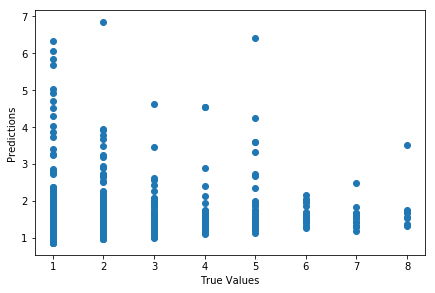

In [85]:
# Model training and prediction
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# print(lr.coef_)
# print(lr.intercept_)

y_pred = lr.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print('Test Score: ', lr.score(X_train, y_train))
print('Test Score: ', lr.score(X_test, y_test))
rrs = ((y_test - y_pred) ** 2).sum()
print('RRS: ', rrs)

Test Score:  0.12325614198142365
Test Score:  0.12412346175255085
RRS:  5928.180761024356


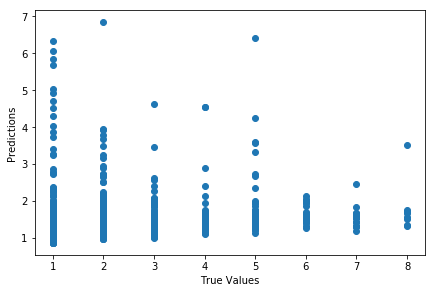

In [84]:
# With regularization
from sklearn.linear_model import Ridge

rr = Ridge(alpha=1.0)
rr.fit(X_train, y_train)
y_pred_ridge = rr.predict(X_test)

plt.scatter(y_test, y_pred_ridge)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print('Test Score: ', rr.score(X_train, y_train))
print('Test Score: ', rr.score(X_test, y_test))
rrs = ((y_test - y_pred) ** 2).sum()
print('RRS: ', rrs)

In [81]:
# Model K-fold cross-validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
k = 5
scores = cross_val_score(lin_reg, X_train, y_train, cv=k)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [0.13270873 0.11549014 0.11789862 0.10810432 0.12001861]
